# AST Edit Distance Scoring Mechanism

### Designing the scoring Algorithm

- Normalization with `ASTNormalizer`:
    - Replaces variable and function names with placeholders (`VAR` and `FUNC`).
    - Ensures comparison is based on structure, not variable naming.

- Tree Conversion:
    - Converts normalized AST into a tree structure compatible with `zss`.
    - Each AST node is represented by its type (e.g., `FunctionDef`, `Return`).

- Edit Distance with `zss`:
    - Computes the minimum number of operations (insertions, deletions, substitutions) required to transform one tree into another.

- Similarity Score:
    - Converts edit distance into a normalized similarity score between 0 and 1.
    - Adjusts for code length to ensure fair scoring.


In [1]:
import ast
from zss import simple_distance, Node

- Normalizes the AST by replacing variable names and argument names

In [ ]:
class ASTNormalizer(ast.NodeTransformer):
    
    def visit_Name(self, node):
        # Replace all variable names with a placeholder
        return ast.copy_location(ast.Name(id="VAR", ctx=node.ctx), node)

    def visit_arg(self, node):
        # Replace argument names with a placeholder
        node.arg = "ARG"
        return node

    def visit_FunctionDef(self, node):
        # Normalize function names
        node.name = "FUNC"
        self.generic_visit(node)
        return node

- Normalize an AST to focus on structure rather than specific names.

In [ ]:
def normalize_ast(tree):
    normalizer = ASTNormalizer()
    return normalizer.visit(tree)

- Convert an AST into a tree structure suitable for zss library

In [5]:
def build_tree(node):
    if not isinstance(node, ast.AST):
        # If the node isn't an AST node, return its string representation
        return Node(str(node))
    # Create a tree node with the type of the AST node
    root = Node(type(node).__name__)
    # Recursively add children nodes
    for child in ast.iter_child_nodes(node):
        root.addkid(build_tree(child))
    return root


- Compute the edit distance between two pieces of Python code

In [6]:
def compute_ast_edit_distance(code1, code2):
    # Parse the code into ASTs
    ast1 = ast.parse(code1)
    ast2 = ast.parse(code2)
    
    # Normalize the ASTs
    norm_ast1 = normalize_ast(ast1)
    norm_ast2 = normalize_ast(ast2)
    
    # Convert ASTs to tree structures
    tree1 = build_tree(norm_ast1)
    tree2 = build_tree(norm_ast2)
    
    # Compute the edit distance using zss
    return simple_distance(tree1, tree2)

- Convert edit distance to a similarity score (1 means identical, 0 means completely different)

In [8]:
def ast_similarity_score(code1, code2):
    # Compute edit distance
    distance = compute_ast_edit_distance(code1, code2)
    
    # Normalize the distance to a similarity score
    # (You can adjust the normalization formula as needed)
    max_possible_distance = max(len(code1), len(code2))
    similarity_score = 1 - (distance / max_possible_distance)
    return max(0, similarity_score)  # Ensure score is non-negative

- Sample Demonstration of the Scoring Mechanism

In [10]:
code_1 = """
def is_even(n):
    return n % 2 == 0
"""

code_2 = """
def check(var_1):
    if var_1 % 2 == 0:
        return True
    else:
        return False
"""

edit_distance = compute_ast_edit_distance(code_1, code_2)
similarity = ast_similarity_score(code_1, code_2)

print(f"AST Edit Distance: {edit_distance}")
print(f"AST Similarity Score: {similarity:.2f}")

AST Edit Distance: 5.0
AST Similarity Score: 0.95


<hr>

### Loading the Model and Vocabulary

In [16]:
import torch, pickle
from torch.utils.data import DataLoader, Dataset
from nltk.translate.bleu_score import sentence_bleu

from prompt_model import Encoder, EncoderLayer, PositionwiseFeedforwardLayer, MultiHeadAttentionLayer, Decoder, DecoderLayer, Seq2Seq

model_path = 'models/conversational-ai-model-cpu.pt'
model = torch.load(model_path)

with open('./vocabs/source_vocab.pkl', 'rb') as f:
        src_vocab = pickle.load(f)

with open('./vocabs/target_vocab.pkl', 'rb') as f:
        trg_vocab = pickle.load(f)

In [17]:
from torchtext.data import Field

SRC = Field(tokenize=lambda x: x.split(),
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

TRG = Field(tokenize=lambda x: x.split(),
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)
SRC.vocab = src_vocab
TRG.vocab = trg_vocab

<hr>

### Converting prompts and replies to Torch Tensors

In [18]:
import spacy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50000):
    model.eval()
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for _ in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(
                trg_tensor, enc_src, trg_mask, src_mask)
        pred_token = output.argmax(2)[:, -1].item()
        trg_indexes.append(pred_token)
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:], attention

In [19]:
from tokenize import untokenize

def eng_to_python(src):
    src = src.split(" ")
    translation, _ = translate_sentence(src, SRC, TRG, model, device)
    return untokenize(translation[:-1]).decode('utf-8')

### Tesing the model scores with AST

- Generating replies using pre-defined prompts

In [20]:
prompts = []
original_replies = []

with open("data/test.txt", "r") as file:
    current_prompt = None
    current_reply = []

    for line in file:
        if line.startswith("#"):
            if current_prompt is not None:
                original_replies.append(''.join(current_reply).strip())

            current_prompt = line.strip("# ").strip()
            prompts.append(current_prompt)
            current_reply = []
        else:
            current_reply.append(line)
    
    if current_prompt is not None:
        original_replies.append(''.join(current_reply).strip())

In [42]:
bot_reply = []

for prompt in prompts:
    bot_reply.append(eng_to_python(prompt))

- Fixing minor syntactic errors within code for compilation

In [56]:
import autopep8
def fix_code(code):
    try:
        code = autopep8.fix_code(code)
        ast.parse(code)  # Validate the corrected code
        return code
    except SyntaxError:
        return None

- Calcualting Scores

In [57]:
ast_scores = []

for original, bot in zip(original_replies, bot_reply):
    reference = original 
    candidate = fix_code(bot)
    if candidate:
        edit_distance = compute_ast_edit_distance(reference, candidate)
        similarity = ast_similarity_score(reference, candidate)
        ast_scores.append({
            "original_replies":reference,
            "model_reply":candidate,
            "edit_distance":edit_distance,
            "similarity": similarity
        })
    else:
        ast_scores.append({
            "original_replies":reference,
            "model_reply":bot,
            "edit_distance": None,
            "similarity": None
        })

ast_scores

[{'original_replies': 'def square(n):\n    return n * n',
  'model_reply': 'def multiply(x, y):\n    return x * y\n',
  'edit_distance': 1.0,
  'similarity': 0.972972972972973},
 {'original_replies': 'def is_even(n):\n    return n % 2 == 0',
  'model_reply': 'def check(var_1):\n    if var_1 == 0:\n        return True\n    else:\n        return False\n',
  'edit_distance': 7.0,
  'similarity': 0.9204545454545454},
 {'original_replies': 'def max_num(a, b):\n    return a if a > b else b',
  'model_reply': 'def lcm(var_1, y):\n    if var_1 > y:\n        return var_1\n    else:\n        return True\n',
  'edit_distance': 5.0,
  'similarity': 0.9431818181818182},
 {'original_replies': 'def reverse_string(s):\n    return s[::-1]',
  'model_reply': 'def reverse_string(str_to_be_reversed):\n    return str_to_be_reversed[:-1]\n',
  'edit_distance': 0.0,
  'similarity': 1.0},
 {'original_replies': 'def sum_list(lst):\n    return sum(lst)',
  'model_reply': 'def cal_total_cap_in_parallel(var_1: li

<hr>

### Visualization of model performance


In [75]:
import pandas as pd

ast_scores_df = pd.DataFrame(ast_scores)

ast_scores_df['edit_distance'] = ast_scores_df['edit_distance'].fillna(-1)
ast_scores_df['similarity'] = ast_scores_df['similarity'].fillna(-1)

def highlight_none(row):
    if row['edit_distance'] == -1 or row['similarity'] == -1:
        return ['background-color: lightcoral'] * len(row)
    return [''] * len(row)

styled_table = ast_scores_df.style.apply(highlight_none, axis=1)
styled_table



,original_replies,model_reply,edit_distance,similarity
0,def square(n): return n * n,"def multiply(x, y): return x * y",1.000000,0.972973
1,def is_even(n): return n % 2 == 0,def check(var_1): if var_1 == 0: return True else: return False,7.000000,0.920455
2,"def max_num(a, b): return a if a > b else b","def lcm(var_1, y): if var_1 > y: return var_1 else: return True",5.000000,0.943182
3,def reverse_string(s): return s[::-1],def reverse_string(str_to_be_reversed): return str_to_be_reversed[:-1],0.000000,1.000000
4,def sum_list(lst): return sum(lst),def cal_total_cap_in_parallel(var_1: list) -> float: return sum(var_1),4.000000,0.946667
5,def factorial(n): if n == 0: return 1 else: return n * factorial(n-1),"def factorial(n): count = 0 for i in range(1, n): count += 1 print(count)",21.000000,0.774194
6,def is_palindrome(s): return s == s[::-1],def isPalindrome(s): return s == s == s[:-1],3.000000,0.938776
7,def celsius_to_fahrenheit(c): return (c * 9/5) + 32,def celsius(var_1): return (var_1 * var_1)/100,5.000000,0.909091
8,"def min_num(a, b, c): return min(a, b, c)","def lcm (a ,b ): return a *a a =5 a =6 a =7 a =a =a *a a =a a a =a +b a =a +b a +b a =a +b a +b a =a +b a a =a +b a a =a a +b a +b a =a +b a ) a =a a =a +b a a +b a =a print (a )",-1.000000,-1.000000
9,"def count_char(s, char): return s.count(char)",def reverse_string(str1): return str1[:-1],8.000000,0.836735


- Histogram for Valid and Failed Cases

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

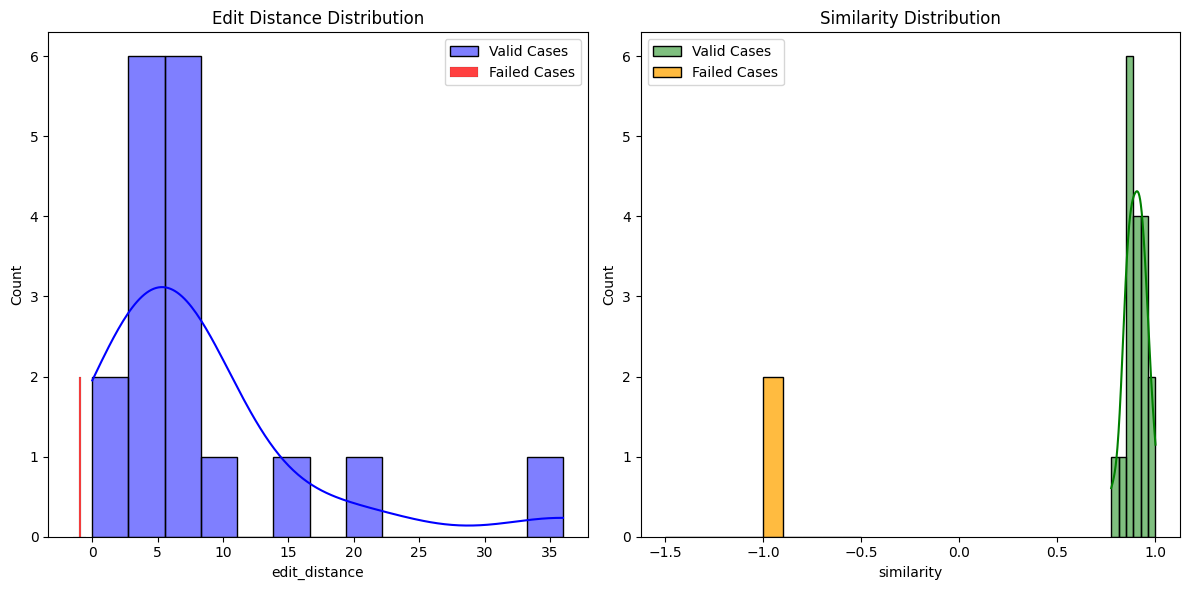

In [79]:
valid_edit_distance = ast_scores_df[ast_scores_df['edit_distance'] != -1]
failed_edit_distance = ast_scores_df[ast_scores_df['edit_distance'] == -1]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(valid_edit_distance['edit_distance'], kde=True, color='blue', label='Valid Cases')
sns.histplot(failed_edit_distance['edit_distance'], kde=False, color='red', label='Failed Cases', bins=10)
plt.title('Edit Distance Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(valid_edit_distance['similarity'], kde=True, color='green', label='Valid Cases')
sns.histplot(failed_edit_distance['similarity'], kde=False, color='orange', label='Failed Cases', bins=10)
plt.title('Similarity Distribution')
plt.legend()

plt.tight_layout()
plt.show()


- Violin Plot with Highlighted Failed Cases

C:\Users\Asus vivobook\AppData\Local\Temp\ipykernel_40064\3499438384.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='status', y='edit_distance', data=ast_scores_df, palette={'failed': 'red', 'valid': 'blue'})
C:\Users\Asus vivobook\AppData\Local\Temp\ipykernel_40064\3499438384.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='status', y='similarity', data=ast_scores_df, palette={'failed': 'red', 'valid': 'green'})


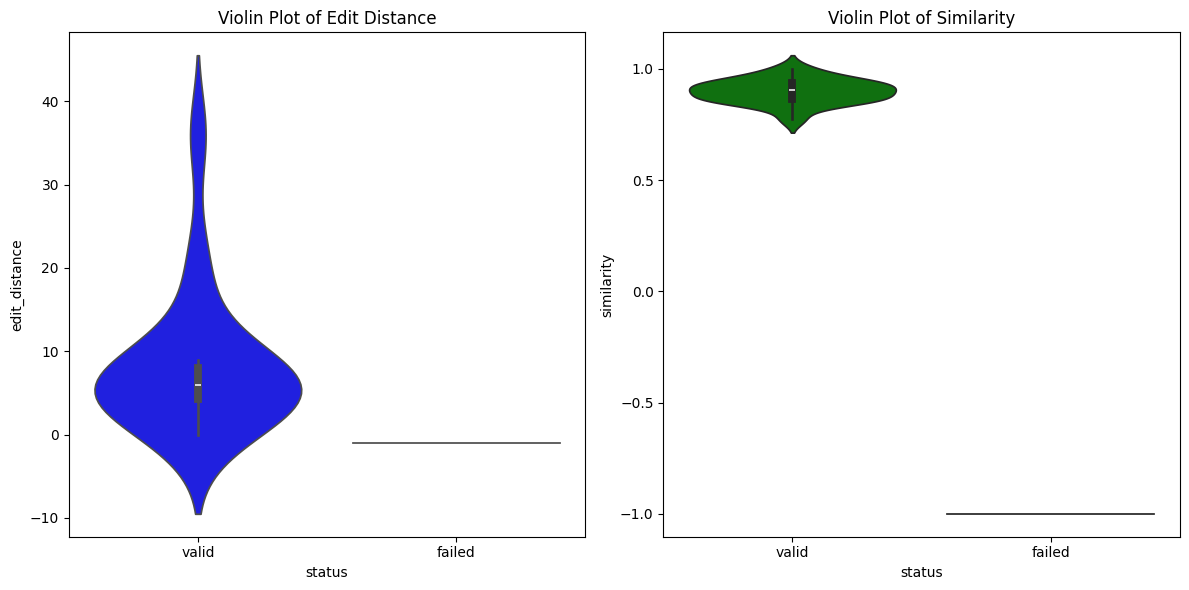

In [84]:
ast_scores_df['status'] = ast_scores_df.apply(lambda row: 'failed' if row['edit_distance'] == -1 or row['similarity'] == -1 else 'valid', axis=1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x='status', y='edit_distance', data=ast_scores_df, palette={'failed': 'red', 'valid': 'blue'})
plt.title('Violin Plot of Edit Distance')

plt.subplot(1, 2, 2)
sns.violinplot(x='status', y='similarity', data=ast_scores_df, palette={'failed': 'red', 'valid': 'green'})
plt.title('Violin Plot of Similarity')

plt.tight_layout()
plt.show()


<hr>